In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('../data/n30w100_dir',
                 data_name='dir', input_type='ascii')

In [4]:
grid.read_raster('../data/n30w100_con',
                 data_name='dem', input_type='ascii')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

In [8]:
dx = np.asarray([profile.size for profile in profiles]) + 1
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = 1.0*np.ones(n)
D = 0.5*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S = (U - V) - Z @ (Y - X) + I

In [9]:
np.imag(np.linalg.eig(S)[0]).max(), np.imag(np.linalg.eig(S)[0]).min(), np.real(np.linalg.eig(S)[0]).max(), np.real(np.linalg.eig(S)[0]).min()

(0.0, 0.0, 0.9752115934621514, -0.2799376721318297)

In [10]:
W_os = []
for i in range(len(S)):
    W_o_i = linalg.solve_discrete_lyapunov(S.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

In [11]:
Ws = []
sr = []
rr = []
ns = 32

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    rr.append(rs[ix])
    sr.append(ix)
    Ws.append(W_os[ix])

In [12]:
W_c = linalg.solve_discrete_lyapunov(S, I)
st = np.argsort(np.diag(W_c))[::-1]

In [13]:
Ws = np.zeros(S.shape)
rt = []

for ix in st:
    w = W_os[ix]
    r = np.linalg.matrix_rank(w + Ws)
    rt.append(r)
    Ws += w

In [14]:
rt = np.asarray(rt)

In [15]:
(rt < len(S)).sum()

213

In [16]:
np.random.seed(0)
sss = [np.random.choice(np.arange(1, len(S)), size=len(S) - 1, replace=False) for _ in range(10)]

In [17]:
rts = []

for ss in sss:
    Ws = np.zeros(S.shape)
    rt = []
    for ix in ss:
        w = W_os[ix]
        r = np.linalg.matrix_rank(w + Ws)
        rt.append(r)
        Ws += w
    rts.append(np.asarray(rt))

In [18]:
np.asarray([(rt < len(S)).sum() for rt in rts]).mean()

141.9

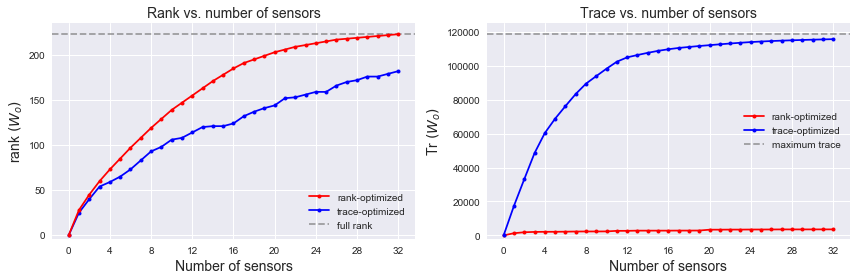

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(np.arange(0, len(rr)+1), [0] + rr[:len(rr)], marker='o', markersize=4, label='rank-optimized', zorder=5, c='r')
ax[0].plot(np.arange(0, len(rr)+1), [0] + rt[:len(rr)], marker='o', markersize=4, label='trace-optimized', c='b')
ax[0].axhline(len(S), linestyle='--', c='0.5', alpha=0.75, label='full rank')
ax[0].xaxis.set_ticks(np.arange(0, 33, 4))
ax[0].set_ylabel('rank $(W_o)$', size=14)
ax[0].set_xlabel('Number of sensors', size=14)
ax[0].set_ylim(-4, 235)
ax[0].legend()
ax[0].set_title('Rank vs. number of sensors', size=14)

ax[1].plot(np.arange(0, len(rr)+1), [0] + np.cumsum(np.diag(W_c)[sr]).tolist()[:len(rr)], marker='o', markersize=4, label='rank-optimized', c='r')
ax[1].plot(np.arange(0, len(rr)+1), [0] + np.cumsum(np.diag(W_c)[st]).tolist()[:len(rr)], marker='o', markersize=4, label='trace-optimized', c='b')
ax[1].axhline(np.diag(W_c).sum(), linestyle='--', c='0.5', alpha=0.75, label='maximum trace')
ax[1].xaxis.set_ticks(np.arange(0, 33, 4))
ax[1].set_ylabel('Tr $(W_o)$', size=14)
ax[1].set_xlabel('Number of sensors', size=14)
ax[1].set_ylim(-2000, 125000)
ax[1].legend()
ax[1].set_title('Trace vs. number of sensors', size=14)

plt.tight_layout()
plt.savefig('rank-trace-vs-num-sensors.png', bbox_inches='tight')